In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_extautoreload
%autoreload 2
from collections import Counter
import random
#from utils import create_dataset

In [16]:
!source /nfs/Sif/victai/pytorch_v4/bin/activate

/bin/sh: 1: source: not found


In [2]:
food_data = pd.read_csv("data/food.csv")
rating_data = pd.read_csv("data/rating_train.csv")
user_data = pd.read_csv("data/user.csv")

In [3]:
food_data.replace('-', np.nan, inplace=True)
rating_data['date'] = rating_data['date'].str.replace('-','')

In [4]:
user_ids = user_data['userid'].sort_values(axis=0).reset_index(drop=True)

In [5]:
print(rating_data[rating_data['userid'] == 8])

          date  userid  foodid
818   20140914       8     209
819   20140914       8     210
820   20140914       8      25
821   20140914       8     211
822   20140914       8     192
823   20140914       8     212
824   20140914       8      48
825   20140914       8      67
826   20140914       8     213
827   20140914       8     125
828   20140914       8     214
829   20140914       8      39
830   20140914       8     107
831   20140914       8     215
832   20140914       8     216
833   20140914       8      61
834   20140914       8     217
835   20140914       8      22
836   20140914       8     218
837   20140915       8      25
838   20140915       8     219
839   20140915       8      25
840   20140915       8     125
841   20140915       8     220
842   20140915       8      69
843   20140915       8      22
844   20140915       8     221
845   20140915       8     222
846   20140915       8     223
847   20140915       8     224
...        ...     ...     ...
1838  20

In [6]:
data_cnt = {}
for i in user_ids:
    data_cnt[i] = len(rating_data[rating_data['userid'] == i])

(array([323., 701., 512., 342., 274., 180., 110.,  65.,  35.,  38.,  13.,
          3.,   7.,   4.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 194.  ,  462.75,  731.5 , 1000.25, 1269.  , 1537.75, 1806.5 ,
        2075.25, 2344.  , 2612.75, 2881.5 , 3150.25, 3419.  , 3687.75,
        3956.5 , 4225.25, 4494.  , 4762.75, 5031.5 , 5300.25, 5569.  ]),
 <a list of 20 Patch objects>)

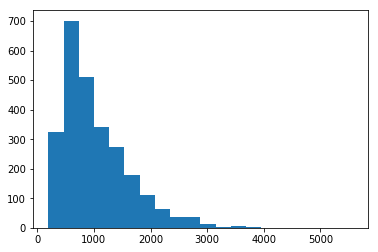

In [7]:
plt.hist(list(data_cnt.values()), bins=20)
#list(data_cnt.values())

In [8]:
user_food_score = [{} for i in range(max(user_ids)+1)]
for u, f in zip(rating_data['userid'], rating_data['foodid']):
    if user_food_score[u].get(f) != None:
        user_food_score[u][f] += 1
    else:
        user_food_score[u][f] = 1
    
for i in user_ids:
    all_val = list(user_food_score[i].values())
    for k, v in user_food_score[i].items():
        user_food_score[i][k] = 1 + (v - min(all_val)) / (max(all_val) - min(all_val)) * 10

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_foods, n_dim):
        super(MatrixFactorization, self).__init__()
        self.user_embed_layer = nn.Embedding(n_users, n_dim)
        self.food_embed_layer = nn.Embedding(n_foods, n_dim)
        
    def forward(self, user_train, food_train):
        user_vec = self.user_embed_layer(user_train)
        food_vec = self.food_embed_layer(food_train)
        return user_vec * food_vec

n_dim = 32
model = MatrixFactorization(len(user_ids), food_data.shape[0], n_dim)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

0.1.12_2


In [10]:
def create_dataset(rating_data, valid_p):
    user_train = []
    user_valid = []
    food_train = []
    food_valid = []
    Y_train = []
    Y_valid = []
    user_ids = pd.unique(rating_data['userid'])
    np.sort(user_ids)
    print(len(user_ids))
    print(user_ids)
    #user_ids = pd.unique(rating_data['userid']).sort_values(axis=0).reset_index(drop=True)
    for u in user_ids:
        current_user = rating_data[rating_data['userid'] == u]
        #print(current_user)
        #print(current_user['userid'])
        #print("userid", u)
        #print(current_user['foodid'].iloc[0])
        cnt = len(current_user) * (1 - valid_p)
        for i in range(len(current_user)):
            if i < cnt:
                user_train.append(u)
                #print(current_user['foodid'])
                #print('i', i, current_user['foodid'][i])
                food_train.append(current_user['foodid'].iloc[i])
                Y_train.append(user_food_score[u][current_user['foodid'].iloc[i]])
            else:
                user_valid.append(u)
                food_valid.append(current_user['foodid'].iloc[i])
                Y_valid.append(user_food_score[u][current_user['foodid'].iloc[i]])
            
                
    return user_train, user_valid, food_train, food_valid, Y_train, Y_valid

In [11]:
valid_percentage = 0.1
user_train, user_valid, food_train, food_valid, Y_train, Y_valid = create_dataset(rating_data, valid_percentage)

order = np.arange(len(user_train))
random.seed(0)
random.shuffle(order)


2608
[   6    8   10 ... 9884 9885 9894]


In [12]:
epochs = 1000
batch_size = 1024
for e in range(epochs):
    t_loss = 0
    for b in range(len(user_train) // batch_size):
        optimizer.zero_grad()
        u_train = Variable(torch.tensor(user_train[b*batch_size: (b+1)*batch_size]))
        f_train = Variable(torch.tensor(food_train[b*batch_size: (b+1)*batch_size]))
        
        pred = model(u_train, f_train)
        loss = loss_func(pred, Y_train[b*batch_size: (b+1)*batch_size])
        t_loss += loss
        loss.backward()
        optimizer.step()
    t_loss /= (len(user_train) // batch_size)
    
    # validation
    v_pred = model(user_valid, food_valid)
    v_loss = loss_func(v_pred, Y_valid)
    
    print("Epoch %d, train_loss = %f, valid_loss = %f"%(e, t_loss, v_loss))

TypeError: 'module' object is not callable